# 基于MindSpore的YOLOv5实现


1. YOLOv5是一种单阶段目标检测算法，该算法在YOLOv4的基础上添加了一些新的改进思路，使其速度与精度都得到了极大的性能提升。

> 1.1 模型结构：
    YOLOv5网络模型主要有四个部分组成，分别为：输入端，Backbone，Neck，Prediction。和YOLOv4相比，YOLOv5做了一些优化，主要有(1) 输入端：Mosaic数据增强、自适应锚框计算、自适应图片缩放，（2）Backbone：Focus结构，CSP结构, (3）Neck：FPN+PAN结构,（4）Prediction：GIOU_Loss。
file:///media/brl/st_brl/Jupyter/dataset/yolov5s_1(1).png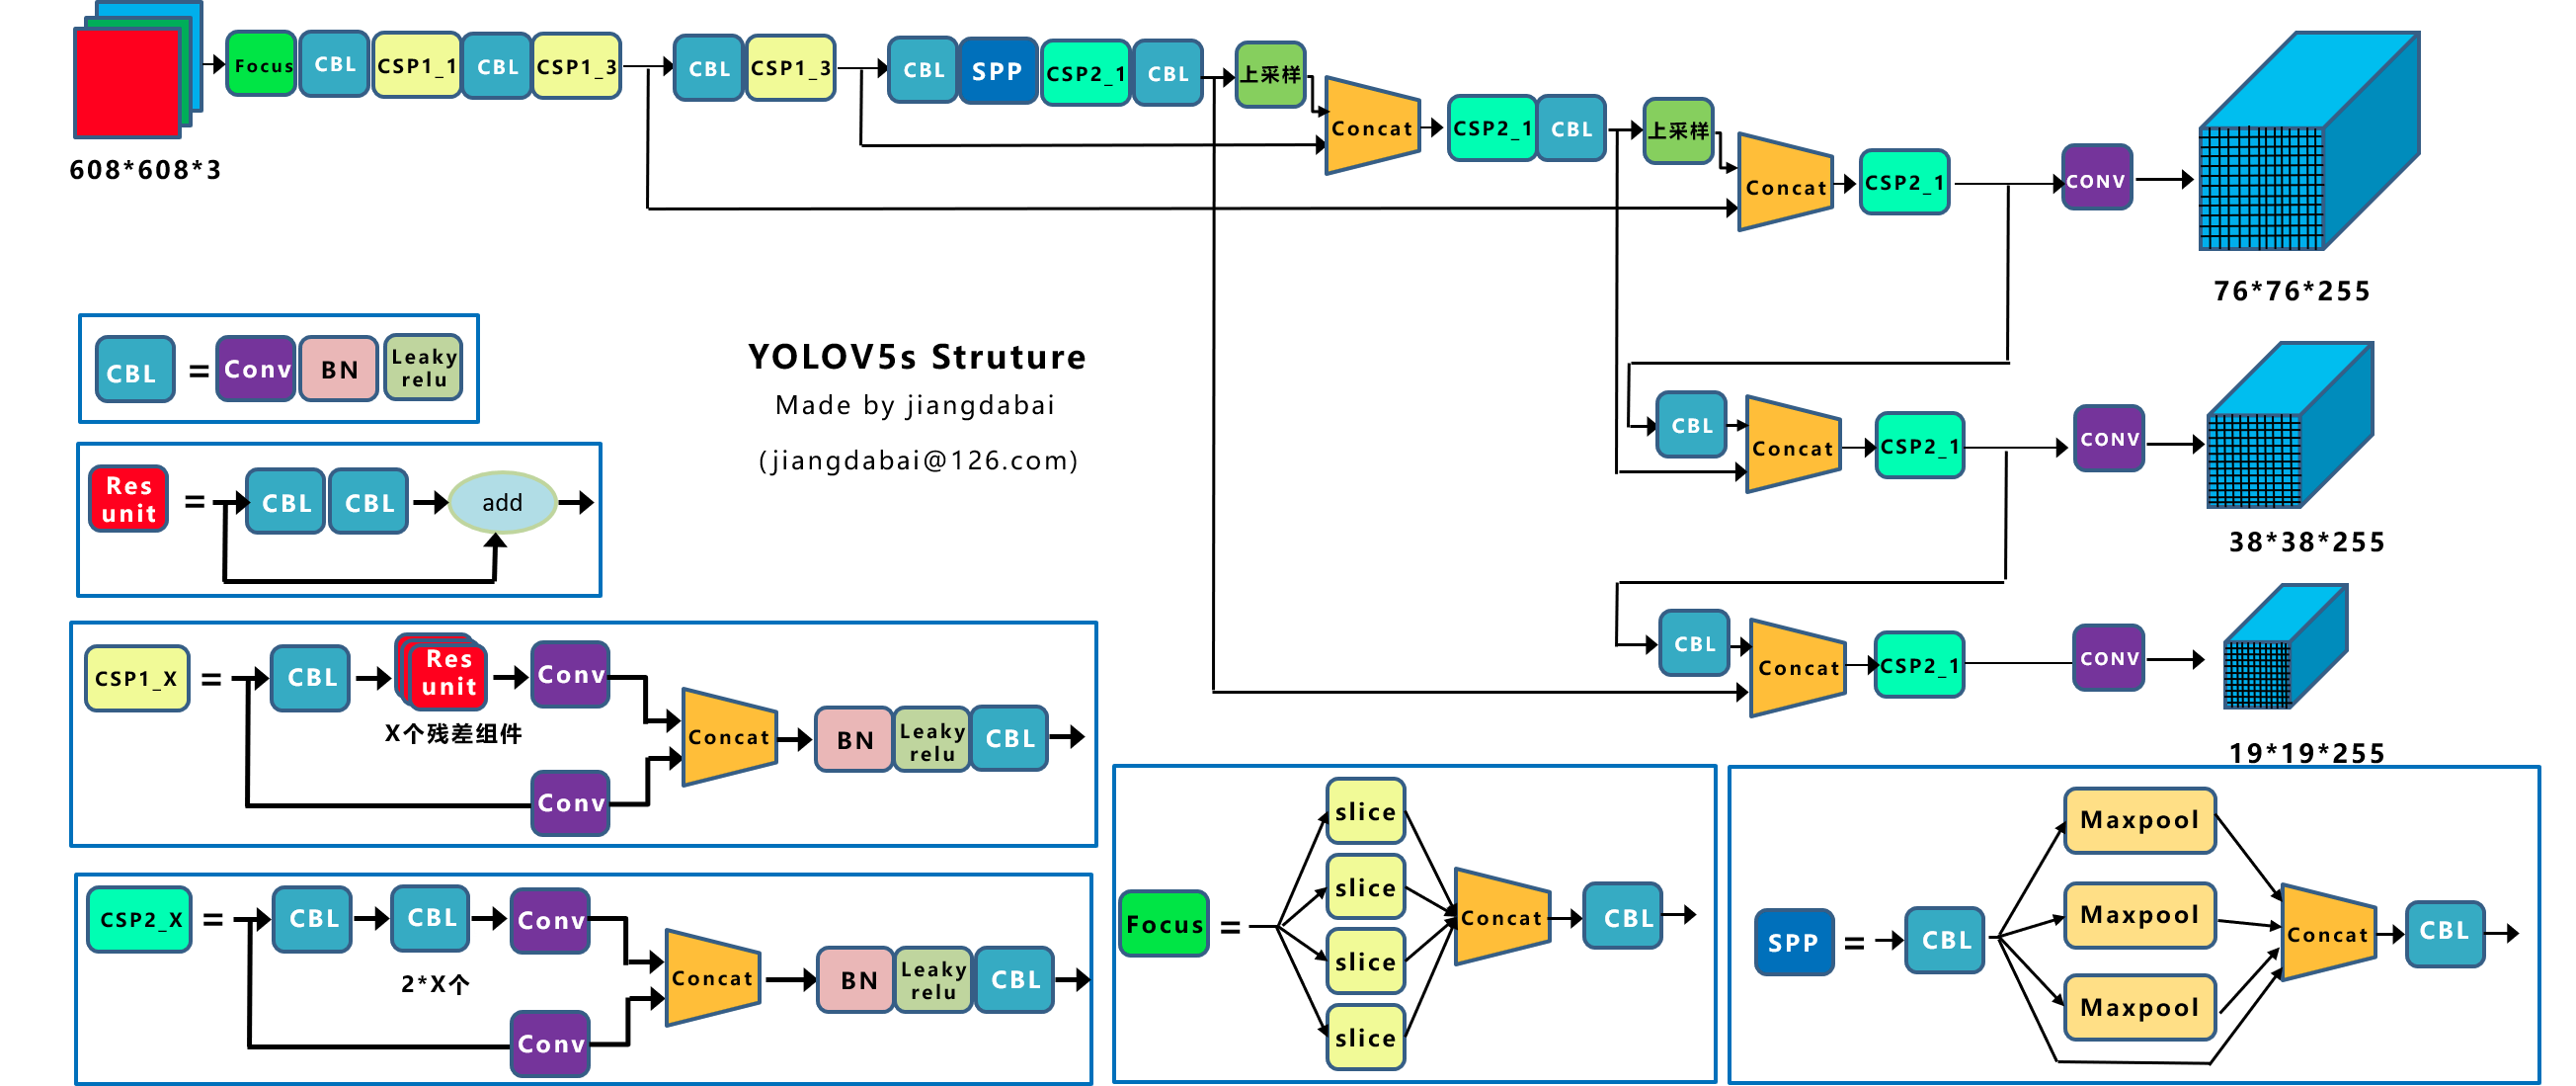

2. 模型实现

> 2.1 环境准备与数据读取
    案例基于MindSpore1.8的GPU版本实现，在GXT1080TI单卡上完成训练。
    案例使用数据集为coco_mini，是从COCO数据集中分离出来的一小部分数据。coco_mini数据集的下联链接为: https://pan.baidu.com/s/1FJ_Css0KoXqKqifmUzmBUw 提取码: g55f。下载好的数据集包括3个文件，分别对应数据标签，训练数据，测试数据，文件路径结构如下：
    
      .datasets/
        └── coco_mini
            ├── annotations
                ├──instances_train2017.json
                └──instances_val2017.json 
            ├── train2017
            └── val2017
     
   > 下面是数据的可视化展示:
    

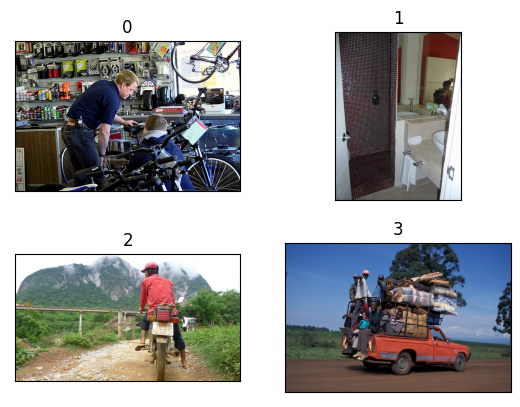

In [2]:
import numpy as np
import matplotlib
import os
import glob
import math
from PIL import Image, ImageSequence
from matplotlib import pyplot as plt

#显示下载好的数据
train_image_path = "dataset/mini_coco_dataset/train2017/"

image = []
for root, dirs, files in os.walk(train_image_path):
    for i in range(6):
        image.append(files[i])

def show_image(image_list,num = 6):
    '''
    #image_list: 图像序列，numpy数组
    #num: 显示图片的数量
    '''
    img_titles = []
    for ind,img in enumerate(image_list):
        if ind == num:
            break
        img_titles.append(ind)

    for i in range(len(img_titles)):
        if len(img_titles) > 6:
            row = 3
        elif 3<len(img_titles)<=6:
            row = 2
        else:
            row = 1
        col = math.ceil(len(img_titles)/row)
        plt.subplot(row,col,i+1),plt.imshow(Image.open(os.path.join(train_image_path, image[i])))
        plt.title(img_titles[i])
        plt.xticks([]),plt.yticks([])
    plt.show()
    
show_image(image,num=4)

> 2.2 模型实现 Backbone

（1）Focus结构：其中比较关键是切片操作。比如下图的切片示意图，4 * 4 * 3的图像切片后变成2 * 2 * 12的特征图
    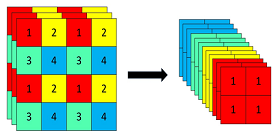
（2）CSP结构： Yolov5中设计了两种CSP结构，CSP1_X结构应用于Backbone主干网络，另一种CSP2_X结构则应用于Neck中。
    file:///media/brl/st_brl/Jupyter/dataset/yolov5s_2.png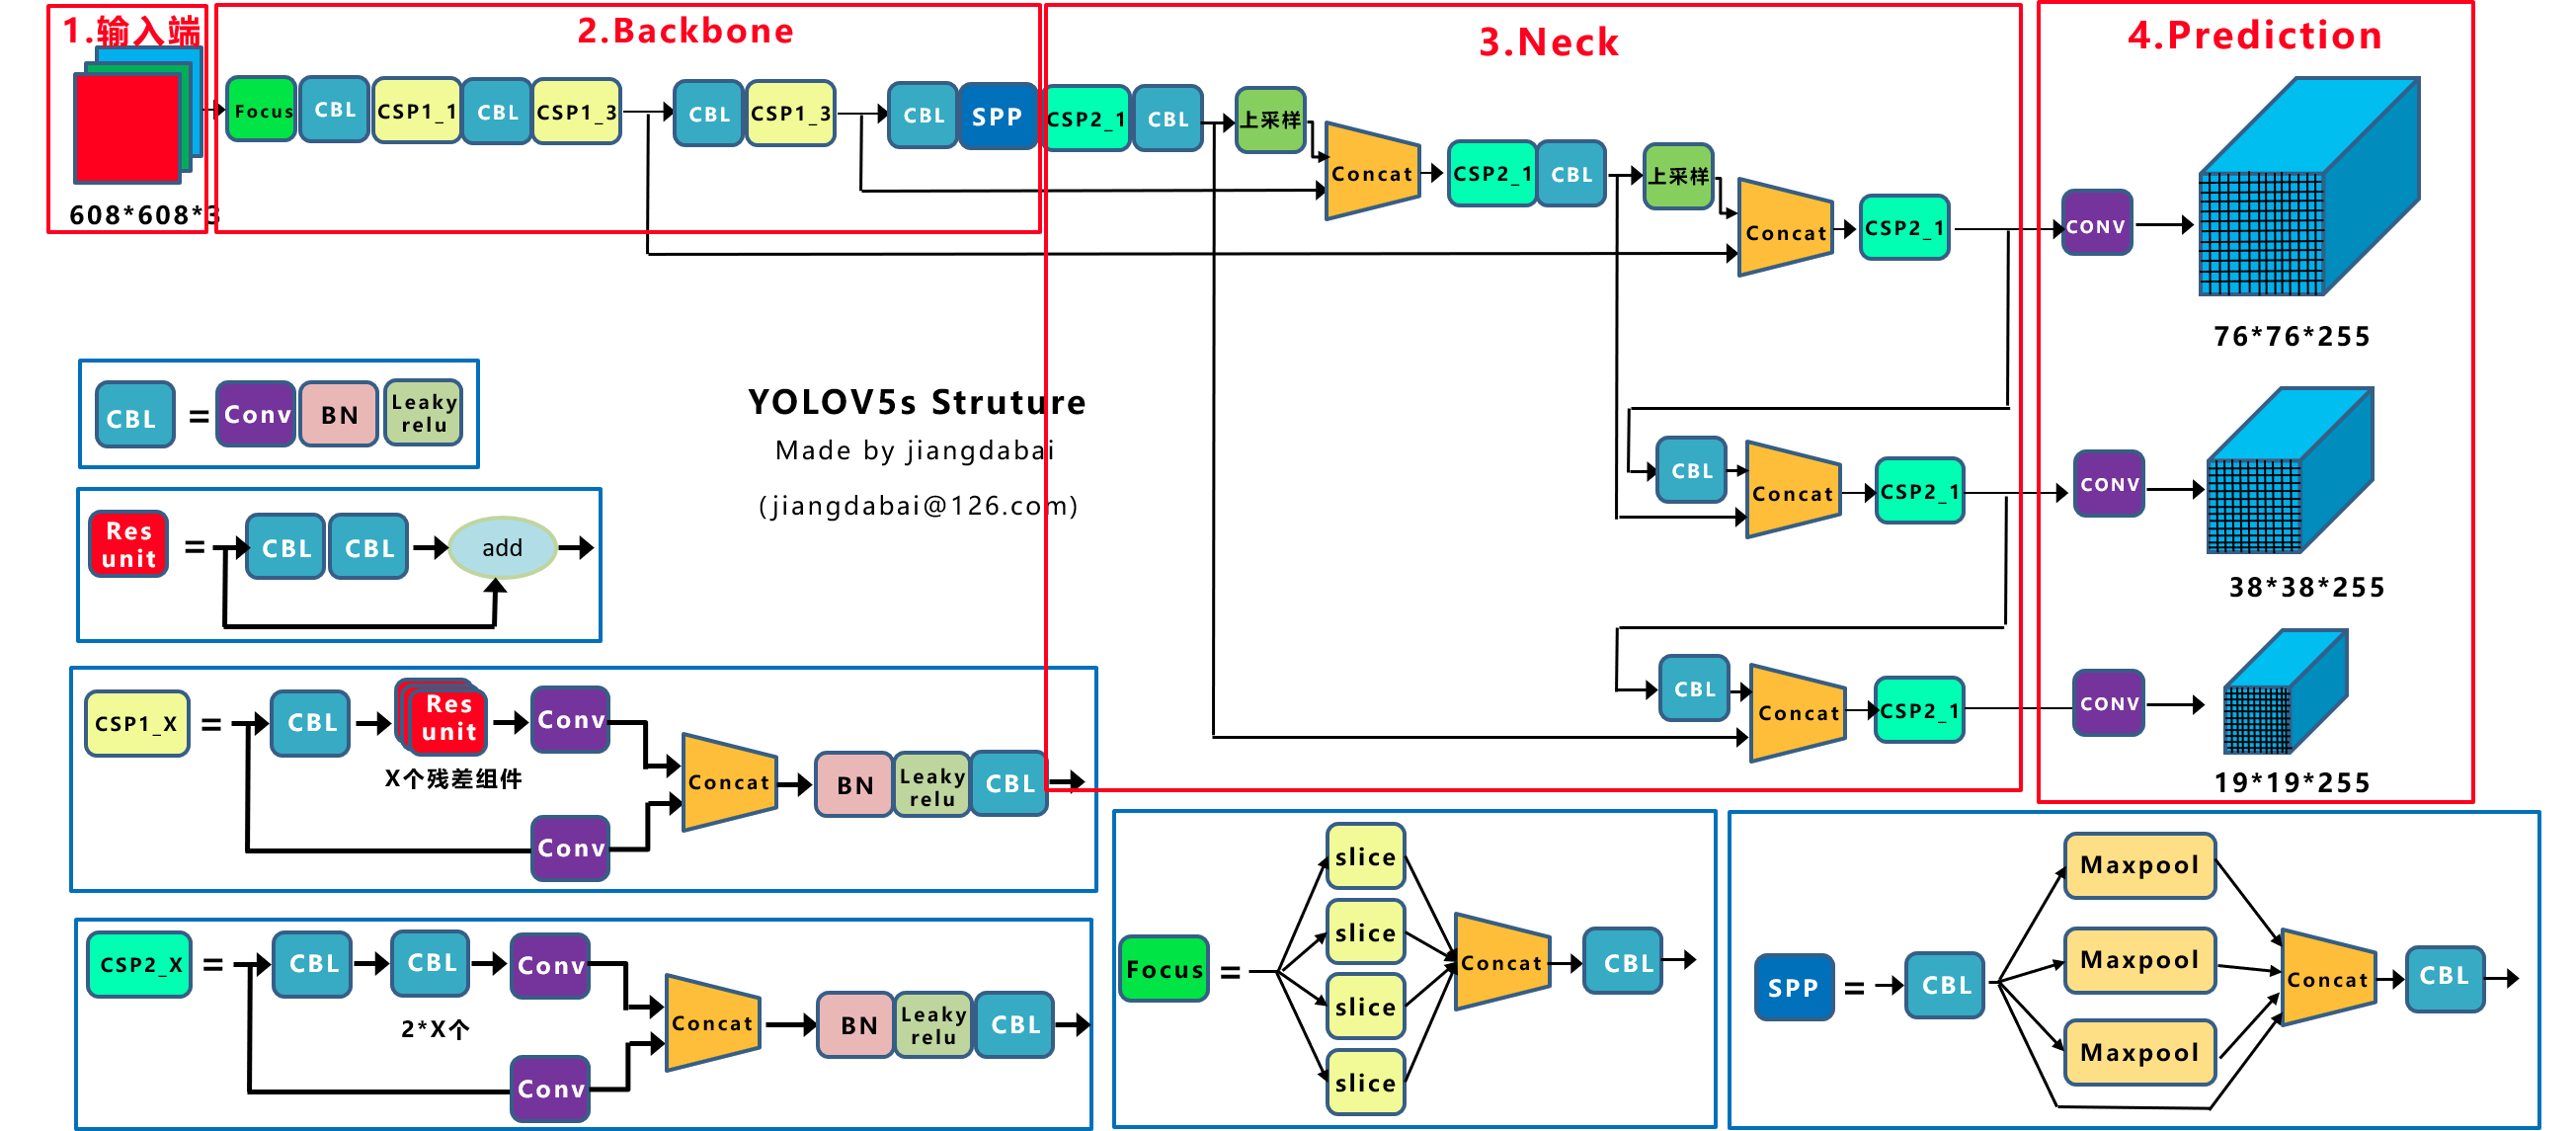

In [1]:
"""DarkNet model."""
import mindspore.nn as nn
import mindspore.ops as ops


class Bottleneck(nn.Cell):
    # Standard bottleneck
    # ch_in, ch_out, shortcut, groups, expansion
    def __init__(self, c1, c2, shortcut=True, e=0.5):
        super(Bottleneck, self).__init__()
        c_ = int(c2 * e)  # hidden channels
        self.conv1 = Conv(c1, c_, 1, 1)
        self.conv2 = Conv(c_, c2, 3, 1)
        self.add = shortcut and c1 == c2

    def construct(self, x):
        c1 = self.conv1(x)
        c2 = self.conv2(c1)
        out = c2
        if self.add:
            out = x + out
        return out


class BottleneckCSP(nn.Cell):
    # CSP Bottleneck with 3 convolutions
    def __init__(self, c1, c2, n=1, shortcut=True, e=0.5):
        super(BottleneckCSP, self).__init__()
        c_ = int(c2 * e)  # hidden channels
        self.conv1 = Conv(c1, c_, 1, 1)
        self.conv2 = Conv(c1, c_, 1, 1)
        self.conv3 = Conv(2 * c_, c2, 1)  # act=FReLU(c2)
        self.m = nn.SequentialCell(
            [Bottleneck(c_, c_, shortcut, e=1.0) for _ in range(n)])
        self.concat = ops.Concat(axis=1)

    def construct(self, x):
        c1 = self.conv1(x)
        c2 = self.m(c1)
        c3 = self.conv2(x)
        c4 = self.concat((c2, c3))
        c5 = self.conv3(c4)

        return c5


class SPP(nn.Cell):
    # Spatial pyramid pooling layer used in YOLOv3-SPP
    def __init__(self, c1, c2, k=(5, 9, 13)):
        super(SPP, self).__init__()
        c_ = c1 // 2  # hidden channels
        self.conv1 = Conv(c1, c_, 1, 1)
        self.conv2 = Conv(c_ * (len(k) + 1), c2, 1, 1)

        self.maxpool1 = nn.MaxPool2d(kernel_size=5, stride=1, pad_mode='same')
        self.maxpool2 = nn.MaxPool2d(kernel_size=9, stride=1, pad_mode='same')
        self.maxpool3 = nn.MaxPool2d(kernel_size=13, stride=1, pad_mode='same')
        self.concat = ops.Concat(axis=1)

    def construct(self, x):
        c1 = self.conv1(x)
        m1 = self.maxpool1(c1)
        m2 = self.maxpool2(c1)
        m3 = self.maxpool3(c1)
        c4 = self.concat((c1, m1, m2, m3))
        c5 = self.conv2(c4)
        return c5


class Focus(nn.Cell):
    # Focus wh information into c-space
    def __init__(self, c1, c2, k=1, s=1, p=None, act=True):
        super(Focus, self).__init__()
        self.conv = Conv(c1 * 4, c2, k, s, p, act)

    def construct(self, x):
        c1 = self.conv(x)
        return c1


class SiLU(nn.Cell):
    def __init__(self):
        super(SiLU, self).__init__()
        self.sigmoid = ops.Sigmoid()

    def construct(self, x):
        return x * self.sigmoid(x)


def auto_pad(k, p=None):  # kernel, padding
    # Pad to 'same'
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
    return p


class Conv(nn.Cell):
    # Standard convolution
    def __init__(self, c1, c2, k=1, s=1, p=None,
                 dilation=1,
                 alpha=0.1,
                 momentum=0.97,
                 eps=1e-3,
                 pad_mode="same",
                 act=True):  # ch_in, ch_out, kernel, stride, padding
        super(Conv, self).__init__()
        self.padding = auto_pad(k, p)
        self.pad_mode = None
        if self.padding == 0:
            self.pad_mode = 'same'
        elif self.padding == 1:
            self.pad_mode = 'pad'
        self.conv = nn.Conv2d(
            c1,
            c2,
            k,
            s,
            padding=self.padding,
            pad_mode=self.pad_mode,
            has_bias=False)
        self.bn = nn.BatchNorm2d(c2, momentum=momentum, eps=eps)
        self.act = SiLU() if act is True else (
            act if isinstance(act, nn.Cell) else ops.Identity())

    def construct(self, x):
        return self.act(self.bn(self.conv(x)))


class YOLOv5Backbone(nn.Cell):
    def __init__(self, shape):
        super(YOLOv5Backbone, self).__init__()
        self.focus = Focus(shape[0], shape[1], k=3, s=1)
        self.conv1 = Conv(shape[1], shape[2], k=3, s=2)
        self.CSP1 = BottleneckCSP(shape[2], shape[2], n=1 * shape[6])
        self.conv2 = Conv(shape[2], shape[3], k=3, s=2)
        self.CSP2 = BottleneckCSP(shape[3], shape[3], n=3 * shape[6])
        self.conv3 = Conv(shape[3], shape[4], k=3, s=2)
        self.CSP3 = BottleneckCSP(shape[4], shape[4], n=3 * shape[6])
        self.conv4 = Conv(shape[4], shape[5], k=3, s=2)
        self.spp = SPP(shape[5], shape[5], k=[5, 9, 13])
        self.CSP4 = BottleneckCSP(shape[5], shape[5], n=1 * shape[6], shortcut=False)

    def construct(self, x):
        """construct method"""
        c1 = self.focus(x)
        c2 = self.conv1(c1)
        c3 = self.CSP1(c2)
        c4 = self.conv2(c3)
        # out
        c5 = self.CSP2(c4)
        c6 = self.conv3(c5)
        # out
        c7 = self.CSP3(c6)
        c8 = self.conv4(c7)
        c9 = self.spp(c8)
        # out
        c10 = self.CSP4(c9)
        return c5, c7, c10


In [3]:
#  model
import mindspore as ms
import mindspore.nn as nn
import mindspore.ops as ops

from src.backbone import YOLOv5Backbone, Conv, BottleneckCSP
from src.loss import ConfidenceLoss, ClassLoss

# from model_utils.config import config as default_config


# param
define_anchor_scales= [[12, 16],
                [19, 36],
                [40, 28],
                [36, 75],
                [76, 55],
                [72, 146],
                [142, 110],
                [192, 243],
                [459, 401]]

define_num_classes = 80

define_input_shape = [[3, 32, 64, 128, 256, 512, 1],
              [3, 48, 96, 192, 384, 768, 2],
              [3, 64, 128, 256, 512, 1024, 3],
              [3, 80, 160, 320, 640, 1280, 4]]


class YoloBlock(nn.Cell):
    """
    YoloBlock for YOLOv5.

    Args:
        in_channels: Integer. Input channel.
        out_channels: Integer. Output channel.

    Returns:
        Tuple, tuple of output tensor,(f1,f2,f3).

    Examples:
        YoloBlock(12, 255)

    """
    def __init__(self, in_channels, out_channels):
        super(YoloBlock, self).__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, has_bias=True)

    def construct(self, x):
        """construct method"""

        out = self.conv(x)
        return out

class YOLO(nn.Cell):
    def __init__(self, backbone, shape):
        super(YOLO, self).__init__()
        self.backbone = backbone
        self.out_channel = (80 + 5) * 3

        self.conv1 = Conv(shape[5], shape[4], k=1, s=1)
        self.CSP5 = BottleneckCSP(shape[5], shape[4], n=1*shape[6], shortcut=False)
        self.conv2 = Conv(shape[4], shape[3], k=1, s=1)
        self.CSP6 = BottleneckCSP(shape[4], shape[3], n=1*shape[6], shortcut=False)
        self.conv3 = Conv(shape[3], shape[3], k=3, s=2)
        self.CSP7 = BottleneckCSP(shape[4], shape[4], n=1*shape[6], shortcut=False)
        self.conv4 = Conv(shape[4], shape[4], k=3, s=2)
        self.CSP8 = BottleneckCSP(shape[5], shape[5], n=1*shape[6], shortcut=False)
        self.back_block1 = YoloBlock(shape[3], self.out_channel)
        self.back_block2 = YoloBlock(shape[4], self.out_channel)
        self.back_block3 = YoloBlock(shape[5], self.out_channel)

        self.concat = ops.Concat(axis=1)

    def construct(self, x):
        """
        input_shape of x is (batch_size, 3, h, w)
        feature_map1 is (batch_size, backbone_shape[2], h/8, w/8)
        feature_map2 is (batch_size, backbone_shape[3], h/16, w/16)
        feature_map3 is (batch_size, backbone_shape[4], h/32, w/32)
        """
        img_height = x.shape[2] * 2
        img_width = x.shape[3] * 2

        feature_map1, feature_map2, feature_map3 = self.backbone(x)

        c1 = self.conv1(feature_map3)
        ups1 = ops.ResizeNearestNeighbor((img_height // 16, img_width // 16))(c1)
        c2 = self.concat((ups1, feature_map2))
        c3 = self.CSP5(c2)
        c4 = self.conv2(c3)
        ups2 = ops.ResizeNearestNeighbor((img_height // 8, img_width // 8))(c4)
        c5 = self.concat((ups2, feature_map1))
        # out
        c6 = self.CSP6(c5)
        c7 = self.conv3(c6)

        c8 = self.concat((c7, c4))
        # out
        c9 = self.CSP7(c8)
        c10 = self.conv4(c9)
        c11 = self.concat((c10, c1))
        # out
        c12 = self.CSP8(c11)
        small_object_output = self.back_block1(c6)
        medium_object_output = self.back_block2(c9)
        big_object_output = self.back_block3(c12)
        return small_object_output, medium_object_output, big_object_output


class DetectionBlock(nn.Cell):


    def __init__(self, scale, is_training=True):
        super(DetectionBlock, self).__init__()
        if scale == 's':
            idx = (0, 1, 2)
            self.scale_x_y = 1.2
            self.offset_x_y = 0.1
        elif scale == 'm':
            idx = (3, 4, 5)
            self.scale_x_y = 1.1
            self.offset_x_y = 0.05
        elif scale == 'l':
            idx = (6, 7, 8)
            self.scale_x_y = 1.05
            self.offset_x_y = 0.025
        else:
            raise KeyError("Invalid scale value for DetectionBlock")
        self.anchors = ms.Tensor([define_anchor_scales[i] for i in idx], ms.float32)
        self.num_anchors_per_scale = 3
        self.num_attrib = 4+1+define_num_classes
        self.lambda_coord = 1

        self.sigmoid = nn.Sigmoid()
        self.reshape = ops.Reshape()
        self.tile = ops.Tile()
        self.concat = ops.Concat(axis=-1)
        self.pow = ops.Pow()
        self.transpose = ops.Transpose()
        self.exp = ops.Exp()
        self.conf_training = is_training

    def construct(self, x, input_shape):
        """construct method"""
        num_batch = x.shape[0]
        grid_size = x.shape[2:4]

        # Reshape and transpose the feature to [n, grid_size[0], grid_size[1], 3, num_attrib]
        prediction = self.reshape(x, (num_batch,
                                      self.num_anchors_per_scale,
                                      self.num_attrib,
                                      grid_size[0],
                                      grid_size[1]))
        prediction = self.transpose(prediction, (0, 3, 4, 1, 2))

        grid_x = ms.numpy.arange(grid_size[1])
        grid_y = ms.numpy.arange(grid_size[0])
        # Tensor of shape [grid_size[0], grid_size[1], 1, 1] representing the coordinate of x/y axis for each grid
        # [batch, gridx, gridy, 1, 1]
        grid_x = self.tile(self.reshape(grid_x, (1, 1, -1, 1, 1)), (1, grid_size[0], 1, 1, 1))
        grid_y = self.tile(self.reshape(grid_y, (1, -1, 1, 1, 1)), (1, 1, grid_size[1], 1, 1))
        # Shape is [grid_size[0], grid_size[1], 1, 2]
        grid = self.concat((grid_x, grid_y))

        box_xy = prediction[:, :, :, :, :2]
        box_wh = prediction[:, :, :, :, 2:4]
        box_confidence = prediction[:, :, :, :, 4:5]
        box_probs = prediction[:, :, :, :, 5:]

        # gridsize1 is x
        # gridsize0 is y
        box_xy = (self.scale_x_y * self.sigmoid(box_xy) - self.offset_x_y + grid) / \
                 ops.cast(ops.tuple_to_array((grid_size[1], grid_size[0])), ms.float32)
        # box_wh is w->h
        box_wh = self.exp(box_wh) * self.anchors / input_shape

        box_confidence = self.sigmoid(box_confidence)
        box_probs = self.sigmoid(box_probs)

        if self.conf_training:
            return prediction, box_xy, box_wh
        return self.concat((box_xy, box_wh, box_confidence, box_probs))

class YOLOV5(nn.Cell):
    """
    YOLOV5 network.

    Args:
        is_training: Bool. Whether train or not.

    Returns:
        Cell, cell instance of YOLOV5 neural network.

    Examples:
        YOLOV5s(True)
    """

    def __init__(self, is_training, version=0):
        super(YOLOV5, self).__init__()

        # YOLOv5 network
        self.shape = define_input_shape[version]
        self.feature_map = YOLO(backbone=YOLOv5Backbone(shape=self.shape), shape=self.shape)

        # prediction on the default anchor boxes
        self.detect_1 = DetectionBlock('l', is_training=is_training)
        self.detect_2 = DetectionBlock('m', is_training=is_training)
        self.detect_3 = DetectionBlock('s', is_training=is_training)

    def construct(self, x, input_shape):
        small_object_output, medium_object_output, big_object_output = self.feature_map(x)
        output_big = self.detect_1(big_object_output, input_shape)
        output_me = self.detect_2(medium_object_output, input_shape)
        output_small = self.detect_3(small_object_output, input_shape)
        # big is the final output which has smallest feature map
        return output_big, output_me, output_small




In [ ]:
import mindspore as ms
from mindspore import Tensor
import numpy as np
x = Tensor(np.zeros([2, 12, 224, 224]), ms.float32)
input_shape = x.shape[2:4]


model = YOLOV5(is_training=True,version=0)
out = model(x,input_shape)


print("模型输入:", x.shape)
print("output_big输出:", np.array(out[0],dtype=object).shape)
print("output_me输出:", np.array(out[1],dtype=object).shape)
print("output_small输出:", np.array(out[2],dtype=object).shape)


模型输入: (2, 12, 224, 224)
output_big输出: (3, 2, 14, 14, 3)
output_me输出: (3, 2, 28, 28, 3)


In [ ]:
# loss
class Iou(nn.Cell):
    """Calculate the iou of boxes"""
    def __init__(self):
        super(Iou, self).__init__()
        self.min = ops.Minimum()
        self.max = ops.Maximum()
        self.squeeze = ops.Squeeze(-1)

    def construct(self, box1, box2):
        """
        box1: pred_box [batch, gx, gy, anchors, 1,      4] ->4: [x_center, y_center, w, h]
        box2: gt_box   [batch, 1,  1,  1,       maxbox, 4]
        convert to topLeft and rightDown
        """
        box1_xy = box1[:, :, :, :, :, :2]
        box1_wh = box1[:, :, :, :, :, 2:4]
        box1_mins = box1_xy - box1_wh / ops.scalar_to_array(2.0) # topLeft
        box1_maxs = box1_xy + box1_wh / ops.scalar_to_array(2.0) # rightDown

        box2_xy = box2[:, :, :, :, :, :2]
        box2_wh = box2[:, :, :, :, :, 2:4]
        box2_mins = box2_xy - box2_wh / ops.scalar_to_array(2.0)
        box2_maxs = box2_xy + box2_wh / ops.scalar_to_array(2.0)

        intersect_mins = self.max(box1_mins, box2_mins)
        intersect_maxs = self.min(box1_maxs, box2_maxs)
        intersect_wh = self.max(intersect_maxs - intersect_mins, ops.scalar_to_array(0.0))
        # self.squeeze: for effiecient slice
        intersect_area = self.squeeze(intersect_wh[:, :, :, :, :, 0:1]) * \
                         self.squeeze(intersect_wh[:, :, :, :, :, 1:2])
        box1_area = self.squeeze(box1_wh[:, :, :, :, :, 0:1]) * \
                    self.squeeze(box1_wh[:, :, :, :, :, 1:2])
        box2_area = self.squeeze(box2_wh[:, :, :, :, :, 0:1]) * \
                    self.squeeze(box2_wh[:, :, :, :, :, 1:2])
        iou = intersect_area / (box1_area + box2_area - intersect_area)
        # iou : [batch, gx, gy, anchors, maxboxes]
        return iou
    
class GIou(nn.Cell):
    """Calculating giou"""
    def __init__(self):
        super(GIou, self).__init__()
        self.reshape = ops.Reshape()
        self.min = ops.Minimum()
        self.max = ops.Maximum()
        self.concat = ops.Concat(axis=1)
        self.mean = ops.ReduceMean()
        self.div = ops.RealDiv()
        self.eps = 0.000001

    def construct(self, box_p, box_gt):
        """construct method"""
        box_p_area = (box_p[..., 2:3] - box_p[..., 0:1]) * (box_p[..., 3:4] - box_p[..., 1:2])
        box_gt_area = (box_gt[..., 2:3] - box_gt[..., 0:1]) * (box_gt[..., 3:4] - box_gt[..., 1:2])
        x_1 = self.max(box_p[..., 0:1], box_gt[..., 0:1])
        x_2 = self.min(box_p[..., 2:3], box_gt[..., 2:3])
        y_1 = self.max(box_p[..., 1:2], box_gt[..., 1:2])
        y_2 = self.min(box_p[..., 3:4], box_gt[..., 3:4])
        intersection = (y_2 - y_1) * (x_2 - x_1)
        xc_1 = self.min(box_p[..., 0:1], box_gt[..., 0:1])
        xc_2 = self.max(box_p[..., 2:3], box_gt[..., 2:3])
        yc_1 = self.min(box_p[..., 1:2], box_gt[..., 1:2])
        yc_2 = self.max(box_p[..., 3:4], box_gt[..., 3:4])
        c_area = (xc_2 - xc_1) * (yc_2 - yc_1)
        union = box_p_area + box_gt_area - intersection
        union = union + self.eps
        c_area = c_area + self.eps
        iou = self.div(ops.cast(intersection, ms.float32), ops.cast(union, ms.float32))
        res_mid0 = c_area - union
        res_mid1 = self.div(ops.cast(res_mid0, ms.float32), ops.cast(c_area, ms.float32))
        giou = iou - res_mid1
        giou = ops.clip_by_value(giou, -1.0, 1.0)
        return giou


def xywh2x1y1x2y2(box_xywh):
    boxes_x1 = box_xywh[..., 0:1] - box_xywh[..., 2:3] / 2
    boxes_y1 = box_xywh[..., 1:2] - box_xywh[..., 3:4] / 2
    boxes_x2 = box_xywh[..., 0:1] + box_xywh[..., 2:3] / 2
    boxes_y2 = box_xywh[..., 1:2] + box_xywh[..., 3:4] / 2
    boxes_x1y1x2y2 = ops.Concat(-1)((boxes_x1, boxes_y1, boxes_x2, boxes_y2))

    return boxes_x1y1x2y2


class YoloLossBlock(nn.Cell):
    """
    Loss block cell of YOLOV5 network.
    """
    def __init__(self, scale, config=default_config):
        super(YoloLossBlock, self).__init__()
        self.config = config
        if scale == 's':
            # anchor mask
            idx = (0, 1, 2)
        elif scale == 'm':
            idx = (3, 4, 5)
        elif scale == 'l':
            idx = (6, 7, 8)
        else:
            raise KeyError("Invalid scale value for DetectionBlock")
        self.anchors = ms.Tensor([self.config.anchor_scales[i] for i in idx], ms.float32)
        self.ignore_threshold = ms.Tensor(self.config.ignore_threshold, ms.float32)
        self.concat = ops.Concat(axis=-1)
        self.iou = Iou()
        self.reduce_max = ops.ReduceMax(keep_dims=False)
        self.confidence_loss = ConfidenceLoss()
        self.class_loss = ClassLoss()

        self.reduce_sum = ops.ReduceSum()
        self.select = ops.Select()
        self.equal = ops.Equal()
        self.reshape = ops.Reshape()
        self.expand_dims = ops.ExpandDims()
        self.ones_like = ops.OnesLike()
        self.log = ops.Log()
        self.tuple_to_array = ops.TupleToArray()
        self.g_iou = GIou()

    def construct(self, prediction, pred_xy, pred_wh, y_true, gt_box, input_shape):
        """
        prediction : origin output from yolo
        pred_xy: (sigmoid(xy)+grid)/grid_size
        pred_wh: (exp(wh)*anchors)/input_shape
        y_true : after normalize
        gt_box: [batch, maxboxes, xyhw] after normalize
        """
        object_mask = y_true[:, :, :, :, 4:5]
        class_probs = y_true[:, :, :, :, 5:]
        true_boxes = y_true[:, :, :, :, :4]

        grid_shape = prediction.shape[1:3]
        grid_shape = ops.cast(self.tuple_to_array(grid_shape[::-1]), ms.float32)

        pred_boxes = self.concat((pred_xy, pred_wh))
        true_wh = y_true[:, :, :, :, 2:4]
        true_wh = self.select(self.equal(true_wh, 0.0),
                              self.ones_like(true_wh),
                              true_wh)
        true_wh = self.log(true_wh / self.anchors * input_shape)
        # 2-w*h for large picture, use small scale, since small obj need more precise
        box_loss_scale = 2 - y_true[:, :, :, :, 2:3] * y_true[:, :, :, :, 3:4]

        gt_shape = gt_box.shape
        gt_box = self.reshape(gt_box, (gt_shape[0], 1, 1, 1, gt_shape[1], gt_shape[2]))

        # add one more dimension for broadcast
        iou = self.iou(self.expand_dims(pred_boxes, -2), gt_box)
        # gt_box is x,y,h,w after normalize
        # [batch, grid[0], grid[1], num_anchor, num_gt]
        best_iou = self.reduce_max(iou, -1)
        # [batch, grid[0], grid[1], num_anchor]

        # ignore_mask IOU too small
        ignore_mask = best_iou < self.ignore_threshold
        ignore_mask = ops.cast(ignore_mask, ms.float32)
        ignore_mask = self.expand_dims(ignore_mask, -1)
        # ignore_mask backpro will cause a lot maximunGrad and minimumGrad time consume.
        # so we turn off its gradient
        ignore_mask = ops.stop_gradient(ignore_mask)

        confidence_loss = self.confidence_loss(object_mask, prediction[:, :, :, :, 4:5], ignore_mask)
        class_loss = self.class_loss(object_mask, prediction[:, :, :, :, 5:], class_probs)

        object_mask_me = self.reshape(object_mask, (-1, 1))  # [8, 72, 72, 3, 1]
        box_loss_scale_me = self.reshape(box_loss_scale, (-1, 1))
        pred_boxes_me = xywh2x1y1x2y2(pred_boxes)
        pred_boxes_me = self.reshape(pred_boxes_me, (-1, 4))
        true_boxes_me = xywh2x1y1x2y2(true_boxes)
        true_boxes_me = self.reshape(true_boxes_me, (-1, 4))
        c_iou = self.g_iou(pred_boxes_me, true_boxes_me)
        c_iou_loss = object_mask_me * box_loss_scale_me * (1 - c_iou)
        c_iou_loss_me = self.reduce_sum(c_iou_loss, ())
        loss = c_iou_loss_me * 4 + confidence_loss + class_loss
        batch_size = prediction.shape[0]
        return loss / batch_size

class YoloWithLossCell(nn.Cell):
    """YOLOV5 loss."""
    def __init__(self, network):
        super(YoloWithLossCell, self).__init__()
        self.yolo_network = network
        self.config = default_config
        self.loss_big = YoloLossBlock('l', self.config)
        self.loss_me = YoloLossBlock('m', self.config)
        self.loss_small = YoloLossBlock('s', self.config)
        self.tenser_to_array = ops.TupleToArray()

    def construct(self, x, y_true_0, y_true_1, y_true_2, gt_0, gt_1, gt_2, input_shape):
        input_shape = x.shape[2:4]
        input_shape = ops.cast(self.tenser_to_array(input_shape) * 2, ms.float32)

        yolo_out = self.yolo_network(x, input_shape)
        loss_l = self.loss_big(*yolo_out[0], y_true_0, gt_0, input_shape)
        loss_m = self.loss_me(*yolo_out[1], y_true_1, gt_1, input_shape)
        loss_s = self.loss_small(*yolo_out[2], y_true_2, gt_2, input_shape)
        return loss_l + loss_m + loss_s * 0.2



In [1]:
import argparse
import mindspore as ms


import sys
sys.argv=['']
del sys

ms.set_seed(1)

parser = argparse.ArgumentParser('mindspore coco training')

# device related
parser.add_argument('--device_target', type=str, default='GPU', help='device where the code will be implemented.')

# dataset related
parser.add_argument('--data_dir', default='./dataset/mini_coco_dataset/', type=str, help='Train dataset directory.')
parser.add_argument('--output_dir', default='./dataset/output/', type=str, help='output')
parser.add_argument('--pretrained_checkpoint', default='', type=str, help='pretrained_checkpoint')
parser.add_argument('--per_batch_size', default=8, type=int, help='Batch size for Training. Default: 8')

# network related
parser.add_argument('--yolov5_version', default='yolov5s', type=str,
                    help='The version of YOLOv5, options: yolov5s, yolov5m, yolov5l, yolov5x')
parser.add_argument('--pretrained_backbone', default='', type=str, help='The pretrained file of yolov5. Default: "".')
parser.add_argument('--resume_yolov5', default='', type=str,
                    help='The ckpt file of YOLOv5, which used to fine tune. Default: ""')

# optimizer and lr related
parser.add_argument('--lr_scheduler', default='cosine_annealing', type=str,
                    help='Learning rate scheduler, options: exponential, cosine_annealing. Default: exponential')
parser.add_argument('--lr', default=0.0001, type=float, help='Learning rate. Default: 0.01')
parser.add_argument('--lr_epochs', type=str, default='220,250',
                    help='Epoch of changing of lr changing, split with ",". Default: 220,250')
parser.add_argument('--lr_gamma', type=float, default=0.1,
                    help='Decrease lr by a factor of exponential lr_scheduler. Default: 0.1')
parser.add_argument('--eta_min', type=float, default=0., help='Eta_min in cosine_annealing scheduler. Default: 0')
parser.add_argument('--T_max', type=int, default=30, help='T-max in cosine_annealing scheduler. Default: 320')
parser.add_argument('--max_epoch', type=int, default=30, help='Max epoch num to train the model. Default: 320')
parser.add_argument('--warmup_epochs', default=4, type=float, help='Warmup epochs. Default: 0')
parser.add_argument('--weight_decay', type=float, default=0.0005, help='Weight decay factor. Default: 0.0005')
parser.add_argument('--momentum', type=float, default=0.9, help='Momentum. Default: 0.9')
parser.add_argument('--bind_cpu', default= True, help='Whether bind cpu when distributed training. Default: True')

# loss related
parser.add_argument('--loss_scale', type=int, default=1024, help='Static loss scale. Default: 1024')
parser.add_argument('--label_smooth', type=int, default=0, help='Whether to use label smooth in CE. Default:0')
parser.add_argument('--label_smooth_factor', type=float, default=0.1,
                    help='Smooth strength of original one-hot. Default: 0.1')

# logging related
parser.add_argument('--log_interval', type=int, default=6, help='Logging interval steps. Default: 100')
parser.add_argument('--ckpt_path', type=str, default='outputs/', help='Checkpoint save location. Default: outputs/')
parser.add_argument('--ckpt_interval', type=int, default=None, help='Save checkpoint interval. Default: None')

parser.add_argument('--is_save_on_master', type=int, default=1,
                    help='Save ckpt on master or all rank, 1 for master, 0 for all ranks. Default: 1')

# distributed related
parser.add_argument('--is_distributed', type=int, default=0,
                    help='Distribute train or not, 1 for yes, 0 for no. Default: 1')
parser.add_argument('--rank', type=int, default=0, help='Local rank of distributed. Default: 0')
parser.add_argument('--group_size', type=int, default=1, help='World size of device. Default: 1')

# roma obs
parser.add_argument('--train_url', type=str, default="", help='train url')
# profiler init
parser.add_argument('--need_profiler', type=int, default=0,
                    help='Whether use profiler. 0 for no, 1 for yes. Default: 0')

# reset default config
parser.add_argument('--training_shape', type=str, default="", help='Fix training shape. Default: ""')
parser.add_argument('--resize_rate', type=int, default=10, help='Resize rate for multi-scale training. Default: None')
parser.add_argument('--is_modelArts', type=int, default=0,
                    help='Trainning in modelArts or not, 1 for yes, 0 for no. Default: 0')

args, _ = parser.parse_known_args()

print(args)




Namespace(T_max=30, bind_cpu=True, ckpt_interval=None, ckpt_path='outputs/', data_dir='./dataset/mini_coco_dataset/', device_target='GPU', eta_min=0.0, group_size=1, is_distributed=0, is_modelArts=0, is_save_on_master=1, label_smooth=0, label_smooth_factor=0.1, log_interval=6, loss_scale=1024, lr=0.0001, lr_epochs='220,250', lr_gamma=0.1, lr_scheduler='cosine_annealing', max_epoch=30, momentum=0.9, need_profiler=0, output_dir='./dataset/output/', per_batch_size=8, pretrained_backbone='', pretrained_checkpoint='', rank=0, resize_rate=10, resume_yolov5='', train_url='', training_shape='', warmup_epochs=4, weight_decay=0.0005, yolov5_version='yolov5s')


In [ ]:
import os
import time
import mindspore as ms
import mindspore.nn as nn
import mindspore.communication as comm

from src.yolo import YOLOV5, YoloWithLossCell
from src.logger import get_logger
from src.util import AverageMeter, get_param_groups, cpu_affinity
from src.lr_scheduler import get_lr
from src.yolo_dataset import create_yolo_dataset
from src.initializer import default_recurisive_init, load_yolov5_params
from model_utils.config import config
from model_utils.device_adapter import get_device_id


def train_preprocess():
    if args.lr_scheduler == 'cosine_annealing' and args.max_epoch > args.T_max:
        args.T_max = args.max_epoch

    args.lr_epochs = list(map(int, args.lr_epochs.split(',')))
    args.data_root = os.path.join(args.data_dir, 'train2017')
    args.annFile = os.path.join(args.data_dir, 'annotations/instances_train2017.json')
    args.device_id = get_device_id()
    ms.set_context(mode=ms.GRAPH_MODE, device_target=args.device_target)

    if args.is_distributed:
        # init distributed
        init_distribute()

    # for promoting performance in GPU device
    if args.device_target == "GPU" and args.bind_cpu:
        cpu_affinity(args.rank, min(args.group_size, 8))
    
    # logger module is managed by config, it is used in other function. e.x. config.logger.info("xxx")
    args.logger = get_logger(args.output_dir, args.rank)
    args.logger.save_args(args)



def run_train():
    train_preprocess()

    loss_meter = AverageMeter('loss')
    dict_version = {'yolov5s': 0, 'yolov5m': 1, 'yolov5l': 2, 'yolov5x': 3}
    network = YOLOV5(is_training=True, version=dict_version[args.yolov5_version])
    # default is kaiming-normal
    default_recurisive_init(network)
    load_yolov5_params(args, network)
    network = YoloWithLossCell(network)

    ds = create_yolo_dataset(image_dir=args.data_root, anno_path=args.annFile, is_training=True,
                             batch_size=args.per_batch_size, device_num=args.group_size,
                             rank=args.rank, config=config)
    args.logger.info('Finish loading dataset')

    steps_per_epoch = ds.get_dataset_size()
    lr = get_lr(args, steps_per_epoch)
    opt = nn.Momentum(params=get_param_groups(network), momentum=args.momentum, learning_rate=ms.Tensor(lr),
                      weight_decay=args.weight_decay, loss_scale=args.loss_scale)
    network = nn.TrainOneStepCell(network, opt, args.loss_scale // 2)
    network.set_train()

    data_loader = ds.create_tuple_iterator(do_copy=False)
    first_step = True
    t_end = time.time()

    for epoch_idx in range(args.max_epoch):
        for step_idx, data in enumerate(data_loader):
            images = data[0]
            input_shape = images.shape[2:4]
            input_shape = ms.Tensor(tuple(input_shape[::-1]), ms.float32)
            loss = network(images, data[2], data[3], data[4], data[5], data[6],
                           data[7], input_shape)
            loss_meter.update(loss.asnumpy())

            # it is used for loss, performance output per config.log_interval steps.
            if (epoch_idx * steps_per_epoch + step_idx) % args.log_interval == 0:
                time_used = time.time() - t_end
                if first_step:
                    fps = args.per_batch_size * args.group_size / time_used
                    per_step_time = time_used * 1000
                    first_step = False
                else:
                    fps = args.per_batch_size * args.log_interval * args.group_size / time_used
                    per_step_time = time_used / args.log_interval * 1000
                args.logger.info('epoch[{}], iter[{}], {}, fps:{:.2f} imgs/sec, '
                                   'lr:{}, per step time: {}ms'.format(
                                    epoch_idx + 1, step_idx + 1, loss_meter, fps, 
                                    lr[epoch_idx * steps_per_epoch + step_idx], per_step_time))
                t_end = time.time()
                loss_meter.reset()
        if args.rank == 0:
            ckpt_name = os.path.join(args.output_dir, "yolov5_{}_{}.ckpt".format(epoch_idx + 1, steps_per_epoch))
            ms.save_checkpoint(network, ckpt_name)

    args.logger.info('==========end training===============')


if __name__ == "__main__":
    run_train()



{}
==== 0/1 ==== bind cpu: [0, 1, 2, 3, 4, 5, 6, 7]
2022-09-24 05:01:15,816:INFO:Args:
2022-09-24 05:01:15,816:INFO:--> device_target: GPU
2022-09-24 05:01:15,817:INFO:--> data_dir: ./dataset/mini_coco_dataset/
2022-09-24 05:01:15,817:INFO:--> output_dir: ./dataset/output/
2022-09-24 05:01:15,818:INFO:--> pretrained_checkpoint: 
2022-09-24 05:01:15,818:INFO:--> per_batch_size: 8
2022-09-24 05:01:15,819:INFO:--> yolov5_version: yolov5s
2022-09-24 05:01:15,819:INFO:--> pretrained_backbone: 
2022-09-24 05:01:15,820:INFO:--> resume_yolov5: 
2022-09-24 05:01:15,820:INFO:--> lr_scheduler: cosine_annealing
2022-09-24 05:01:15,821:INFO:--> lr: 0.0001
2022-09-24 05:01:15,821:INFO:--> lr_epochs: [220, 250]
2022-09-24 05:01:15,822:INFO:--> lr_gamma: 0.1
2022-09-24 05:01:15,822:INFO:--> eta_min: 0.0
2022-09-24 05:01:15,823:INFO:--> T_max: 30
2022-09-24 05:01:15,824:INFO:--> max_epoch: 30
2022-09-24 05:01:15,824:INFO:--> warmup_epochs: 4
2022-09-24 05:01:15,824:INFO:--> weight_decay: 0.0005
2022-09

[WARNING] ME(6275:140430981248832,MainProcess):2022-09-24-05:01:16.227.745 [mindspore/dataset/core/config.py:635] The shared memory is on, multiprocessing performance will be improved. Note: the required shared memory can't exceeds 80% of the available shared memory.


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
2022-09-24 05:01:16,856:INFO:Finish loading dataset
2022-09-24 05:01:40,647:INFO:epoch[1], iter[1], loss:8985.517578, fps:0.38 imgs/sec, lr:4.1666667129902635e-06, per step time: 20936.212301254272ms
2022-09-24 05:01:43,873:INFO:epoch[2], iter[1], loss:8050.703044, fps:14.89 imgs/sec, lr:2.9166667445679195e-05, per step time: 537.346363067627ms
2022-09-24 05:01:46,969:INFO:epoch[3], iter[1], loss:4900.794189, fps:15.51 imgs/sec, lr:5.4166666814126074e-05, per step time: 515.7802899678549ms
2022-09-24 05:01:50,124:INFO:epoch[4], iter[1], loss:4041.592367, fps:15.22 imgs/sec, lr:7.916666800156236e-05, per step time: 525.7031917572021ms
